수정사항(2024.04.12 23:12)
- 10배 Oversampling으로 변경, 혹은 OV 변수를 바꾸기 가능
- 그래프 정상적으로 그릴 수 있게 변경
- code_delay_range 변수 조정 : range(-1600,1600,8) => np.arange(-200,200,0.5)
- 신호 생성 시 delay가 소수점일 때 제대로 작동하지 않는 것을 막기 위해 delay에 곱셈 적용
: code_delay = int(code_delay * 10)
- 기타 수치 조정

## Code 생성

In [587]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate
from mpl_toolkits.mplot3d import Axes3D
from collections import deque  
import random as rand

sats = [(1, 5), (2, 6), (3, 7), (4, 8), (0, 8), (1, 9), (0, 7), (1, 8), (2, 9), (1, 2),
            (2, 3), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (0, 3), (1, 4), (2, 5), (3, 6),
            (4, 7), (5, 8), (0, 2), (3, 5), (4, 6), (5, 7), (6, 8), (7, 9), (0, 5), (1, 6),
            (2, 7), (3, 8), (4, 9), (3, 9), (0, 6), (1, 7), (3, 9)]
g1tap = [2,9]
g2tap = [1,2,5,7,8,9]

def getCode(satsNum):
    
    g1 = deque(1 for i in range(10))
    g2 = deque(1 for i in range(10))
    
    # result
    g = []
    
    # Generating 1023 chips(One C/A sequence)
    for i in range(1023):
        val = (g1[9] + g2[satsNum[0]] + g2[satsNum[1]]) % 2
        g.append(val)
        
        #shift g1
        g1[9] = sum(g1[i] for i in g1tap) % 2
        g1.rotate()
        
        #shift g2
        g2[9] = sum(g2[i] for i in g2tap) % 2
        g2.rotate()
    # 0 => -1
    for n,i in enumerate(g):
            if i==0:
                g[n]=-1
        
    return g

# 코드 미리 만들어두기(시간복잡도 줄이려고)
codes = []
for i in range(37):
    codes.append(getCode(sats[i]))

## Oversampling rate 결정

In [588]:
OV = 10
# 확인해 본 sampling : (4,8,10,16,20,50)
# 여기서 문제 있는 sampling 갯수 : 4, 8, 16 : 바로 옆 delay를 판단해버린다. Ex) 16으로 했을 때 True: 33.25, Est: 33.3125(한 sample 차이)

## 송신단에서의 신호 생성 + Doppler_frequency 적용

In [589]:
def generate_transmitted_signal(code_delay, doppler_freq, svNumber, code_freq=1.023e6, oversampling_factor=(1.023e6)*OV, signal_length=1023*OV):
    # Generate C/A code
    ca_code = np.array(codes[svNumber])
    code_delay = int(code_delay * OV)
    # Apply code delay
    delayed_code = [chip for chip in ca_code for _ in range(OV)]
    delayed_code = np.roll(delayed_code, code_delay)
    # Generate oversampled signal
    t = np.arange(signal_length)
   
    code_phase = 2 * np.pi * code_freq * t / oversampling_factor
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * doppler_freq * t / oversampling_factor))
    
    # Multiply with delayed C/A code
    signal = delayed_code * oversampled_signal[:signal_length]
    
    return signal

## 수신단에서의 Replica 신호 생성(For Acquisition)

In [590]:
def generate_replica_signal(code_delay, doppler_freq, svNumber, code_freq=1.023e6, oversampling_factor=(1.023e6)*OV, signal_length=1023*OV):
    # Generate C/A code
    ca_code = np.array(codes[svNumber])
    code_delay = int(code_delay * OV)
    # Apply code delay
    delayed_code = [chip for chip in ca_code for _ in range(OV)]
    delayed_code = np.roll(delayed_code, code_delay)
    # Generate oversampled signal
    t = np.arange(signal_length)
   
    code_phase = 2 * np.pi * code_freq * t / oversampling_factor
    oversampled_signal = np.cos(code_phase) * np.exp(1j * (2 * np.pi * (doppler_freq) * t / oversampling_factor))
    
    # Multiply with delayed C/A code
    signal = delayed_code * oversampled_signal[:signal_length]
    
    return signal

## Acqusition

In [591]:
def acquisition(signal, code_delay_range, doppler_freq_range, svNumber, oversampling_factor=(1.023e6)*OV, signal_length=1023*OV):
    max_corr = 0
    max_code_delay = 0
    max_doppler_freq = 0
    
    corr_matrix = np.zeros((len(code_delay_range), len(doppler_freq_range)))
 
    for i, doppler_freq in enumerate(doppler_freq_range):
        # Generate replica signal with the current code delay and Doppler frequency
        reference_signal = generate_replica_signal(code_delay_range[0], doppler_freq, svNumber, oversampling_factor=oversampling_factor, signal_length=signal_length)
        for j, code_delay in enumerate(code_delay_range):
            
            # Calculate correlation between the received signal and the replica signal
            correlation = np.abs(correlate(signal, reference_signal, mode='valid'))
            
            # Find maximum correlation
            peak_corr = np.max(correlation)
            corr_matrix[j, i] = peak_corr
            
            # Update maximum correlation and corresponding code delay and Doppler frequency
            if peak_corr > max_corr:
                max_corr = peak_corr
                max_code_delay = code_delay
                max_doppler_freq = doppler_freq
    
            # Shift the reference signal by 0.5 chips for the next iteration
            reference_signal = np.roll(reference_signal, OV//2)
    
    return max_corr, max_code_delay, max_doppler_freq, corr_matrix
    


## 실행

In [592]:
# Parameters
code_delay_range = np.arange(-200, 200, 0.5)  # Range of code delay in chips
doppler_freq_range = np.linspace(-5000, 5000, 21)  # Adjusted range of Doppler frequency in Hz
code_freq = 1.023e6  # Code frequency in Hz
svNumber = rand.randint(0,36)
# Generate received signal
true_code_delay = rand.randint(-200*OV,200*OV) / OV
true_doppler_freq = rand.randint(-5000,5000)
received_signal = generate_transmitted_signal(true_code_delay, true_doppler_freq, svNumber, code_freq=code_freq)

# Perform acquisition
max_corr, estimated_code_delay, estimated_doppler_freq, corr_matrix = acquisition(received_signal, code_delay_range, doppler_freq_range, svNumber)

print("-"*40)
print("Target SV Number:", svNumber + 1)
print("True Code Delay:", true_code_delay)
print("True doppler frequency:", true_doppler_freq)
print("Maximum correlation:", max_corr)
print("Estimated code delay:", estimated_code_delay)
print("Estimated Doppler frequency:", estimated_doppler_freq)

----------------------------------------
Target SV Number: 17
True Code Delay: -41.1
True doppler frequency: 3966
Maximum correlation: 4478.099886264441
Estimated code delay: -41.0
Estimated Doppler frequency: 4000.0


## Plot

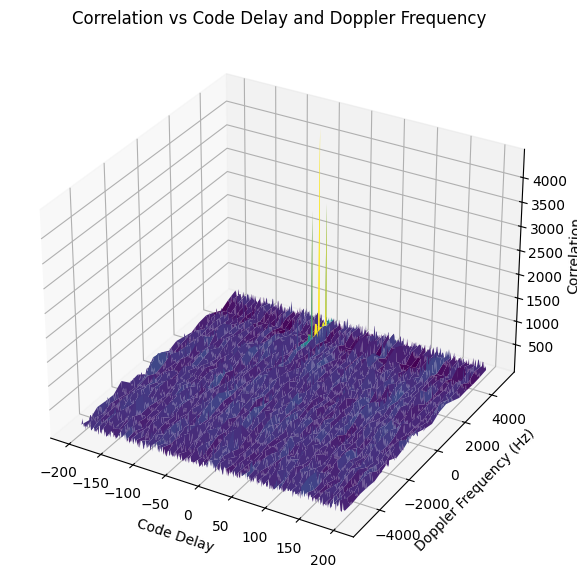

In [593]:
# Plotting
Code_Delay, Doppler_Freq = np.meshgrid(code_delay_range, doppler_freq_range)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Code_Delay, Doppler_Freq, corr_matrix.T, cmap='viridis')
ax.set_xlabel('Code Delay')
ax.set_ylabel('Doppler Frequency (Hz)')
ax.set_zlabel('Correlation')
ax.set_title('Correlation vs Code Delay and Doppler Frequency')
plt.show()


## DLL test

In [594]:
current_code_delay = estimated_code_delay
error_Amp = 100000
count = 0
while(count < 20):
    print(f'{count}: {current_code_delay}', sep = " ")
    # L,P,E Replica Generation
    Early_code = generate_transmitted_signal(current_code_delay - 0.5, estimated_doppler_freq, svNumber)
    Prompt_code = generate_transmitted_signal(current_code_delay, estimated_doppler_freq, svNumber)
    Late_code = generate_transmitted_signal(current_code_delay + 0.5, estimated_doppler_freq, svNumber)
    # Calculate correlation between the received signal and the replica signal
    cor_E = np.abs(correlate(received_signal, Early_code, mode='valid'))
    E = np.max(cor_E)
    cor_P = np.abs(correlate(received_signal, Prompt_code, mode='valid'))
    P = np.max(cor_P)
    cor_L = np.abs(correlate(received_signal, Late_code, mode='valid'))        
    L = np.max(cor_L)
    print(f'P = {P}, E = {E}, L = {L}')
    error_Amp = (E - L)
    if np.abs(error_Amp) < 1:
        print(f'Matched. E = {error_Amp}')
        break 
    else:
        if E - L < 0:
            current_code_delay = round(current_code_delay + 1/OV, 10)
        elif E - L > 0:
            current_code_delay = round(current_code_delay - 1/OV, 10)
        count += 1
    
  
print('L =',L)
print('P =',P)
print('E =',E)

print(f'True: {true_code_delay}, Est: {current_code_delay}')
        
    
    


0: -41.0
P = 4478.099886264443, E = 3336.848224893147, L = 2082.4968505807165
1: -41.1
P = 5105.279149919005, E = 2709.670981118426, L = 2709.671436448449
Matched. E = -0.00045533002321462845
L = 2709.671436448449
P = 5105.279149919005
E = 2709.670981118426
True: -41.1, Est: -41.1
